In [20]:
import numpy as np
import tensorflow as tf

from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('data/', one_hot=False)


class ModelVAE(object):

    def __init__(self, x, h_dim, z_dim, activation=tf.nn.relu, distribution='normal'):
        """
        ModelVAE initializer

        :param x: placeholder for input
        :param h_dim: dimension of the hidden layers
        :param z_dim: dimension of the latent representation
        :param activation: callable activation function
        :param distribution: string either `normal` or `vmf`, indicates which distribution to use
        """
        self.x, self.h_dim, self.z_dim, self.activation, self.distribution = x, h_dim, z_dim, activation, distribution

        self.z_mean, self.z_var = self._encoder(self.x)

        if distribution == 'normal':
            self.q_z = tf.distributions.Normal(self.z_mean, self.z_var)
        elif distribution == 'vmf':
            self.q_z = VonMisesFisher(self.z_mean, self.z_var)
        else:
            raise NotImplemented

        self.z = self.q_z.sample()

        self.logits = self._decoder(self.z)

    def _encoder(self, x):
        """
        Encoder network

        :param x: placeholder for input
        :return: tuple `(z_mean, z_var)` with mean and concentration around the mean
        """
        # dynamic binarization
        x = tf.cast(tf.greater(x, tf.random_uniform(shape=tf.shape(x), dtype=x.dtype)), dtype=x.dtype)
        
        # 2 hidden layers encoder
        h0 = tf.layers.dense(x, units=self.h_dim * 2, activation=self.activation)
        h1 = tf.layers.dense(h0, units=self.h_dim, activation=self.activation)

        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            z_mean = tf.layers.dense(h1, units=self.z_dim, activation=None)
            z_var = tf.layers.dense(h1, units=self.z_dim, activation=tf.nn.softplus)
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            z_mean = tf.layers.dense(h1, units=self.z_dim, activation=lambda x: tf.nn.l2_normalize(x, axis=-1))
            # the `+ 1` prevent collapsing behaviors
            z_var = tf.layers.dense(h1, units=1, activation=tf.nn.softplus) + 1
        else:
            raise NotImplemented

        return z_mean, z_var

    def _decoder(self, z):
        """
        Decoder network

        :param z: tensor, latent representation of input (x)
        :return: logits, `reconstruction = sigmoid(logits)`
        """
        # 2 hidden layers decoder
        h2 = tf.layers.dense(z, units=self.h_dim, activation=self.activation)
        h2 = tf.layers.dense(h2, units=self.h_dim * 2, activation=self.activation)
        logits = tf.layers.dense(h2, units=self.x.shape[-1], activation=None)

        return logits


class OptimizerVAE(object):

    def __init__(self, model, learning_rate=1e-3):
        """
        OptimizerVAE initializer

        :param model: a model object
        :param learning_rate: float, learning rate of the optimizer
        """

        # binary cross entropy error
        self.bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=model.x, logits=model.logits)
        self.reconstruction_loss = tf.reduce_mean(tf.reduce_sum(self.bce, axis=-1))

        if model.distribution == 'normal':
            # KL divergence between normal approximate posterior and standard normal prior
            self.p_z = tf.distributions.Normal(tf.zeros_like(model.z), tf.ones_like(model.z))
            kl = model.q_z.kl_divergence(self.p_z)
            self.kl = tf.reduce_mean(tf.reduce_sum(kl, axis=-1))
        elif model.distribution == 'vmf':
            # KL divergence between vMF approximate posterior and uniform hyper-spherical prior
            self.p_z = HypersphericalUniform(model.z_dim - 1, dtype=model.x.dtype)
            kl = model.q_z.kl_divergence(self.p_z)
            self.kl = tf.reduce_mean(kl)
        else:
            raise NotImplemented

        self.ELBO = - self.reconstruction_loss - self.kl

        self.train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(-self.ELBO)

        self.print = {'recon loss': self.reconstruction_loss, 'ELBO': self.ELBO, 'KL': self.kl}


def log_likelihood(model, optimizer, n=10):
    """

    :param model: model object
    :param optimizer: optimizer object
    :param n: number of MC samples
    :return: MC estimate of log-likelihood
    """

    z = model.q_z.sample(n)

    log_p_z = optimizer.p_z.log_prob(z)

    if model.distribution == 'normal':
        log_p_z = tf.reduce_sum(log_p_z, axis=-1)

    log_p_x_z = -tf.reduce_sum(optimizer.bce, axis=-1)

    log_q_z_x = model.q_z.log_prob(z)

    if model.distribution == 'normal':
        log_q_z_x = tf.reduce_sum(log_q_z_x, axis=-1)

    return tf.reduce_mean(tf.reduce_logsumexp(
        tf.transpose(log_p_x_z + log_p_z - log_q_z_x) - np.log(n), axis=-1))

# hidden dimension and dimension of latent space
#输入是784，隐藏层是128，输出层Z是2
H_DIM = 128
Z_DIM = 2
num_epochs = 50
# digit placeholder
x = tf.placeholder(tf.float32, shape=(None, 784))

#训练VAE modelN

# normal VAE
modelN = ModelVAE(x=x, h_dim=H_DIM, z_dim=Z_DIM, distribution='normal')
optimizerN = OptimizerVAE(modelN)

#训练SVAE 
# hyper-spherical VAE
modelS = ModelVAE(x=x, h_dim=H_DIM, z_dim=Z_DIM + 1, distribution='vmf')
optimizerS = OptimizerVAE(modelS)

session = tf.Session()
session.run(tf.global_variables_initializer())


print('##### Normal VAE #####')

for i in range(1000):
    # training
    x_mb, _ = mnist.train.next_batch(64)
    session.run(optimizerN.train_step, {modelN.x: x_mb})

    # every 100 iteration plot validation
    if i % 100 == 0:
        x_mb = mnist.validation.images
        print(i, session.run({**optimizerN.print}, {modelN.x: x_mb}))

print('Test set:')
x_mb = mnist.test.images
print_ = {**optimizerN.print}
print_['LL'] = log_likelihood(modelN, optimizerN, n=100)
print(session.run(print_, {modelN.x: x_mb}))

print()

print('##### Hyper-spherical VAE #####')
for i in range(1000):
    # training
    x_mb, _ = mnist.train.next_batch(64)
    session.run(optimizerS.train_step, {modelS.x: x_mb})

    # every 100 iteration plot validation
    if i % 100 == 0:
        x_mb = mnist.validation.images
        print(i, session.run({**optimizerS.print}, {modelS.x: x_mb}))

print('Test set:')
x_mb = mnist.test.images
print_ = {**optimizerS.print}
print_['LL'] = log_likelihood(modelS, optimizerS, n=100)
print(session.run(print_, {modelS.x: x_mb}))


Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
##### Normal VAE #####
0 {'KL': 0.15235537, 'ELBO': -540.26337, 'recon loss': 540.111}
100 {'KL': 3.1557777, 'ELBO': -202.05455, 'recon loss': 198.89877}
200 {'KL': 3.7101138, 'ELBO': -188.63762, 'recon loss': 184.9275}
300 {'KL': 4.1480603, 'ELBO': -179.31998, 'recon loss': 175.17192}
400 {'KL': 4.3980656, 'ELBO': -175.23685, 'recon loss': 170.83878}
500 {'KL': 4.250247, 'ELBO': -172.88542, 'recon loss': 168.63518}
600 {'KL': 4.444167, 'ELBO': -171.29672, 'recon loss': 166.85255}
700 {'KL': 4.6675277, 'ELBO': -168.78589, 'recon loss': 164.11836}
800 {'KL': 4.698185, 'ELBO': -167.38467, 'recon loss': 162.6865}
900 {'KL': 4.7772727, 'ELBO': -166.08435, 'recon loss': 161.30708}
Test set:
{'KL': 4.934965, 'ELBO': -166.19702, 'recon loss': 161.26205, 'LL': -165.09695}

##### Hyper-spherical VAE #####
0 {'KL': 0.4019309, 'E

[-0.10140911 -0.1603115  -0.20246255 ... -0.31341863  0.2840111
  0.09852375]
[7 2 1 ... 4 5 6]


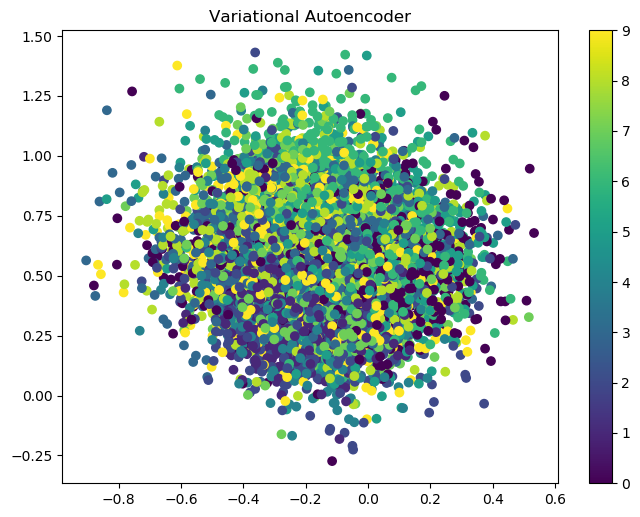

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

x_mb = mnist.test.images

x_test_encoded = modelN._encoder(x_mb)
x_test_encoded = x_test_encoded[0] #取z_mean


session = tf.Session()
session.run(tf.global_variables_initializer())
x_test_encoded = x_test_encoded.eval(session=session)#tensor to list
print(x_test_encoded[:, 0])
print(mnist.test.labels)

plt.figure(figsize=(8, 6), dpi=100)#Create a new figure.
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],c=mnist.test.labels)
plt.title('Variational Autoencoder')
plt.colorbar()
plt.show()



[-0.1528073  0.6634391  0.7324606]


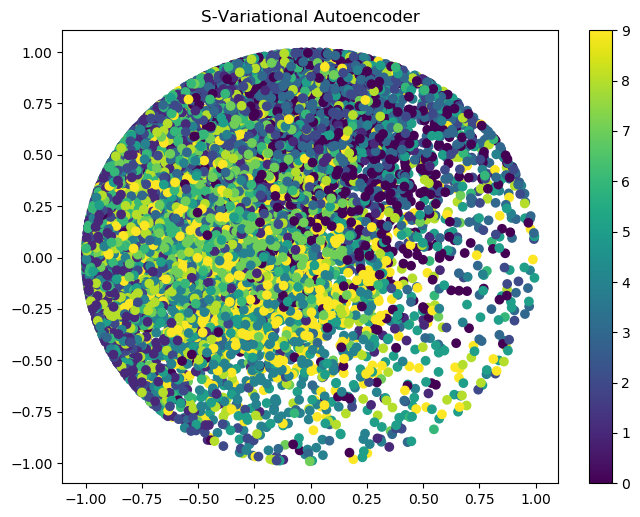

In [5]:
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
'''
elems = np.array([1, 2, 3, 4, 5, 6])
squares = tf.map_fn(lambda x: x * x, elems)
# squares == [1, 4, 9, 16, 25, 36]
'''
# display a 2D plot of the digit classes in the latent space
#x_test_encoded = encoder.predict(x_test, batch_size=batch_size)#100个batch的输出z_mean，z_mean是一个二维的vector
x_mb = mnist.test.images

x_test_encoded = modelS._encoder(x_mb)
x_test_encoded = x_test_encoded[0] #取z_mean



#x_test_encoded = tf.map_fn(lambda x: x,x_test_encoded)
#print(x_test_encoded.shape)
#print(x_test_encoded[:,0].shape)
#print(x_test_encoded[:,1].shape)
#x_test_encoded = Input(shape=x_test_encoded.shape.as_list())
#tensor b, array_b=b.eval()
session = tf.Session()
session.run(tf.global_variables_initializer())
x_test_encoded = x_test_encoded.eval(session=session)
print(x_test_encoded[0])

plt.figure(figsize=(8, 6), dpi=100)#Create a new figure.
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],c=mnist.test.labels)
plt.title('S-Variational Autoencoder')
plt.colorbar()
plt.show()



In [63]:
print(mnist.test.labels)

[7 2 1 ... 4 5 6]
